# LIBRARY

In [3]:
import os

import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# DATA

In [4]:
def plot_data(title, df):
  # Plot data sintetik
  plt.figure(figsize=(10, 6))
  date = df.index
  for column in df.columns.values:
    plt.plot(date,df[column],label=column)
  plt.xlabel('Date')
  plt.xticks(rotation=60)
  plt.ylabel('Value')
  plt.title(title)
  plt.legend()
  plt.show()

## SYNTHETIC

In [5]:
def create_data(N):
  t = np.arange(N)
  trend = 0.01 * t + 0.0001 * t**2
  seasonal_period = 100
  seasonal = 10 * np.sin(2 * np.pi * t / 50) + 5 * np.sin(2 * np.pi * t / 200)
  noise = np.random.normal(0, 1 + 0.01 * t, N)

  synthetic_data = trend + seasonal + noise
  date_index = pd.date_range(start='2000-01-01', periods=N, freq='D')
  df = pd.DataFrame({'Value': synthetic_data, 'Trend': trend, 'Noise': noise, 'Seasonal': seasonal}, index=date_index)
  df.index.name = 'Date'
  return df

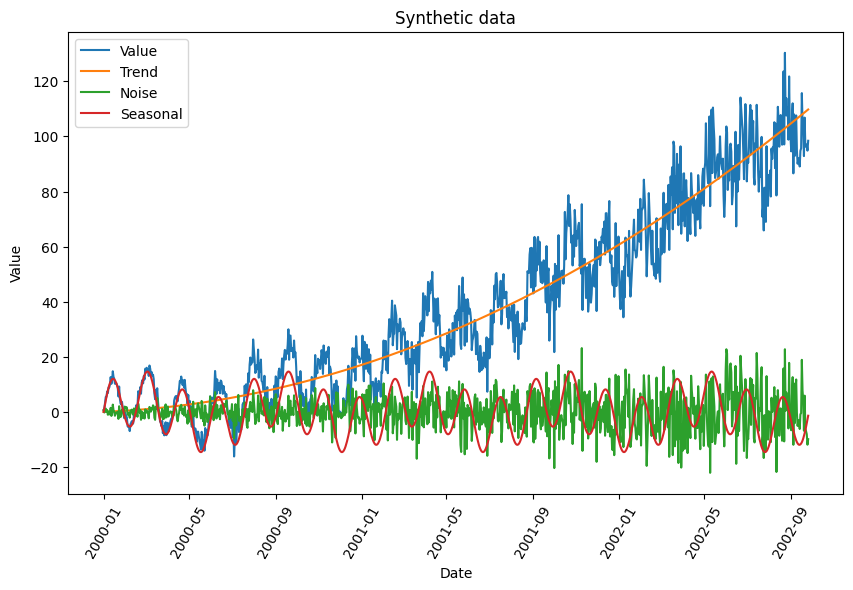

In [6]:
df_synthetic = create_data(1000)
plot_data('Synthetic data',df_synthetic)

## REAL

In [7]:
df = pd.read_csv('../Data/Beban_listrik.csv')

In [8]:
df.head()

,Date,EnergyConsumption
0,01/01/2016,2.540
1,02/01/2016,2.732
2,03/01/2016,2.712
3,04/01/2016,3.007
4,05/01/2016,2.967


In [9]:
df.columns = ['Date', 'Value']
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
# Membagi DataFrame berdasarkan tahun
data_by_year = {year: df[df.index.year == year] for year in df.index.year.unique()}
df_all = df.copy()
df_2016 = data_by_year[2016]
df_2017 = data_by_year[2017]
df_2018 = data_by_year[2018]
df_2019 = data_by_year[2019]
df_2020 = data_by_year[2020]

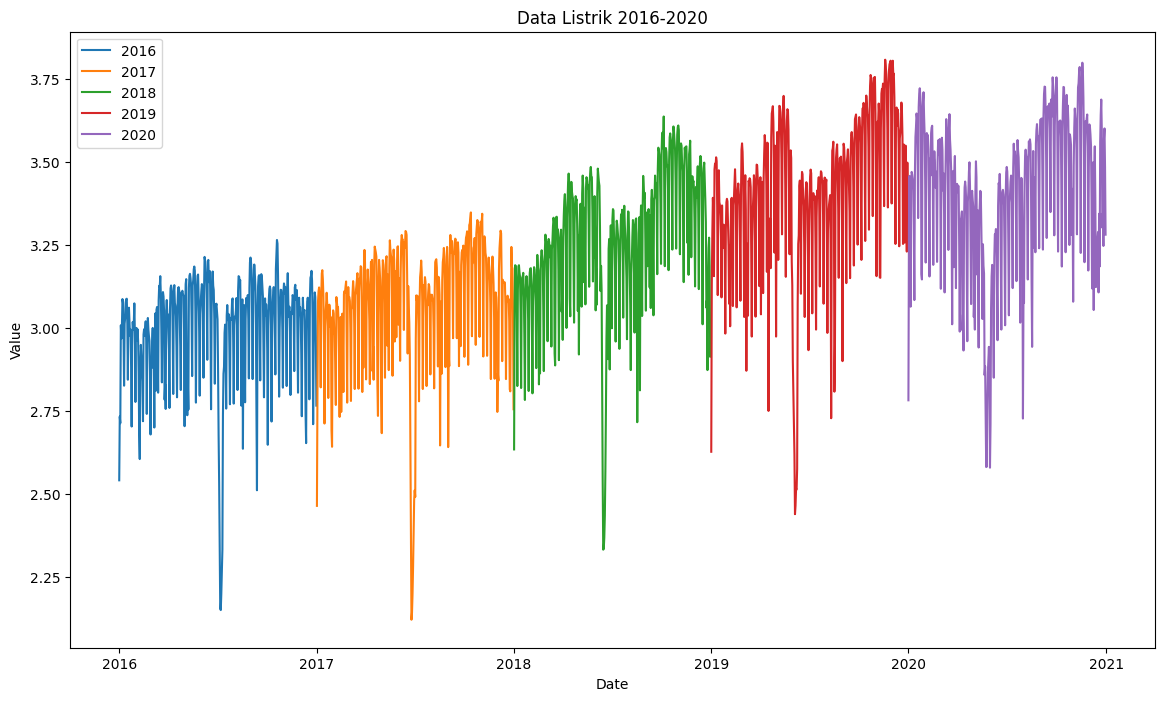

In [10]:
# Plot data listrik 6 tahun
plt.figure(figsize=(14, 8))

plt.plot(df_2016.index, df_2016['Value'], label='2016')
plt.plot(df_2017.index, df_2017['Value'], label='2017')
plt.plot(df_2018.index, df_2018['Value'], label='2018')
plt.plot(df_2019.index, df_2019['Value'], label='2019')
plt.plot(df_2020.index, df_2020['Value'], label='2020')

plt.title('Data Listrik 2016-2020')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

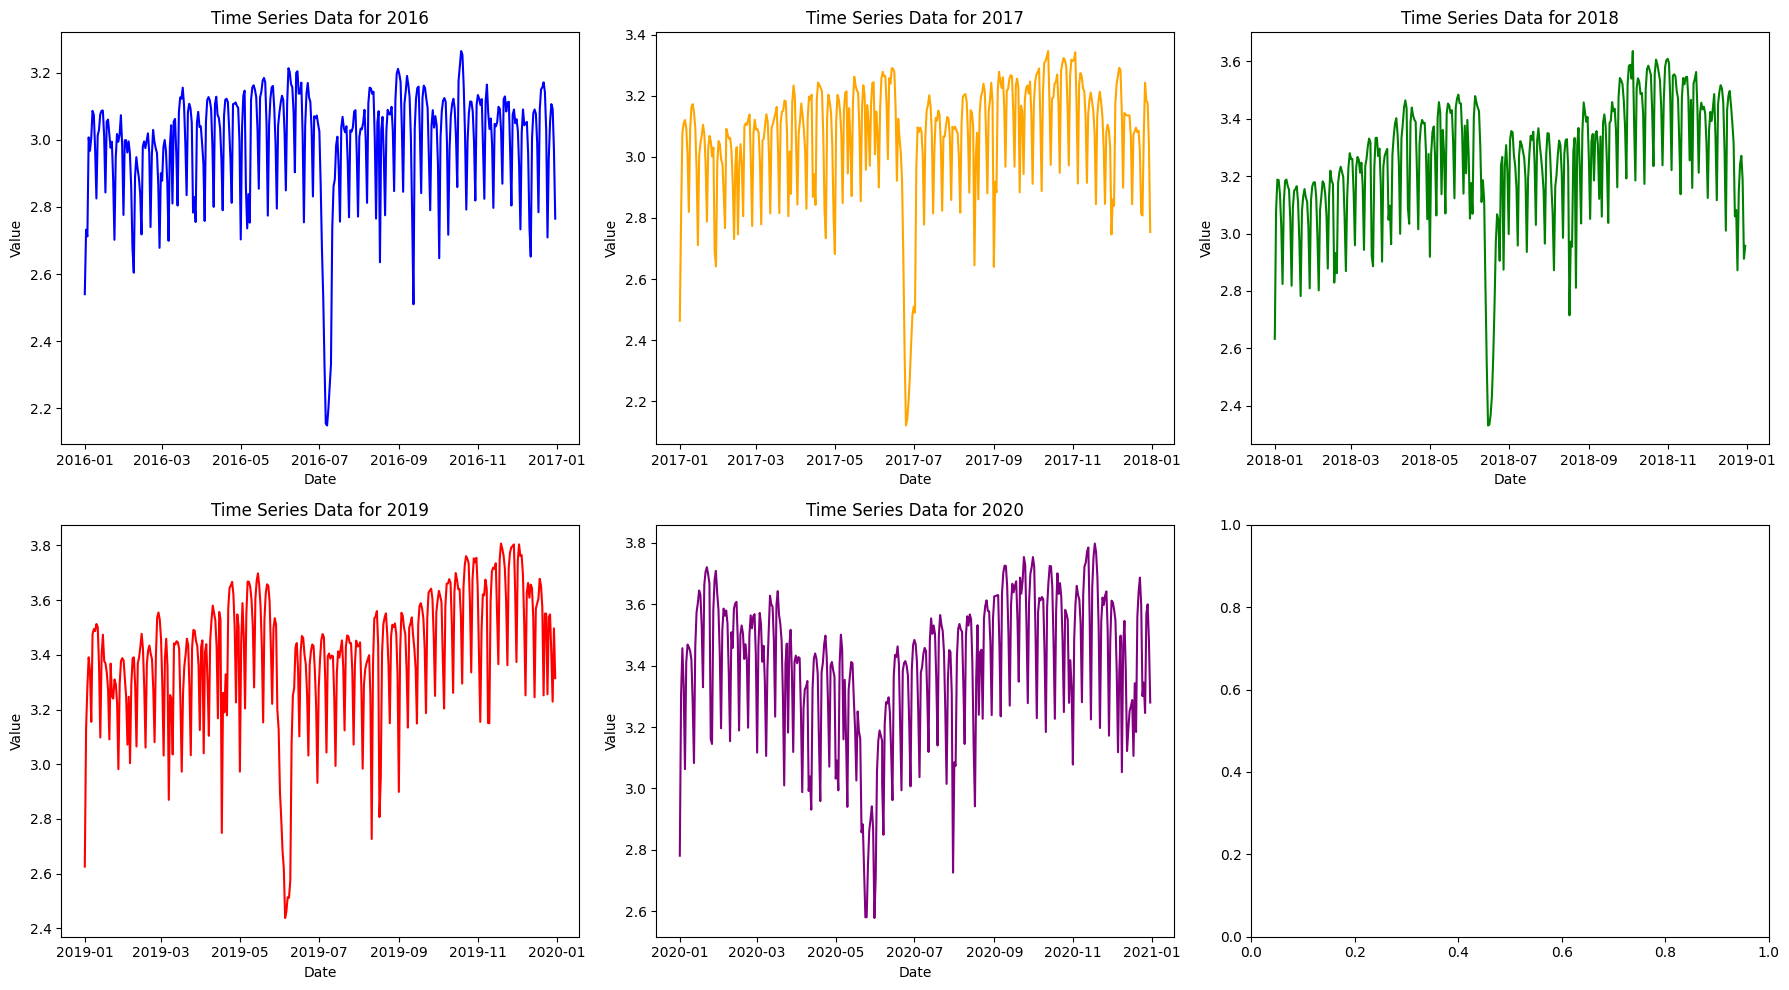

In [13]:
# Plot data listrik setiap tahun dalam subplot terpisah
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=False)

colors = ['blue', 'orange', 'green', 'red', 'purple']
data_by_year_items = list(data_by_year.items())

for ax, (year, data), color in zip(axes.flat, data_by_year_items, colors):
    ax.plot(data.index, data['Value'], color=color)
    ax.set_title(f'Time Series Data for {year}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# SSA


In [30]:
data = df_all.copy()

## Windowing

In [31]:
def windowing(F, L):
  N = len(F)
  K = N - L + 1
  X = np.column_stack([F[i:i+L] for i in range(0,K)])
  return X

In [32]:
N = len(data)
L = 914
K = N - L + 1
X = windowing(data['Value'], L)

## Dekomposisi

In [14]:
def dekomposisi(X):
  d = np.linalg.matrix_rank(X)
  U, Sigma, V = np.linalg.svd(X)
  V = V.T
  X_komponen = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

  if not np.allclose(X, X_komponen.sum(axis=0), atol=1e-10):
      print("WARNING: The sum of X's elementary matrices is not equal to X!")

  return X_komponen, Sigma, d

In [24]:
# Fiddle with figure settings here:
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2

# Set the default colour cycle (in case someone changes it...)
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

def plot_2d(m, title=""):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

def plot_komponen(X_komponen, d):
    d = min(d, 16)
    cols = 4
    rows = math.ceil(d / cols)
    for i in range(d):
        plt.subplot(rows, cols, i + 1)
        title = "$\mathbf{X}_{" + str(i) + "}$"
        plot_2d(X_komponen[i], title)
    plt.tight_layout()

def plot_kontribusi_komponen(Sigma, limit_x):
    sigma_sumsq = (Sigma**2).sum()
    fig, ax = plt.subplots(1, 2, figsize=(14,5))
    ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
    ax[0].set_xlim(0,limit_x)
    ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
    ax[0].set_xlabel("$i$")
    ax[0].set_ylabel("Contribution (%)")
    ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
    ax[1].set_xlim(0,limit_x)
    ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
    ax[1].set_xlabel("$i$")
    ax[1].set_ylabel("Contribution (%)");

def Hankelise(X, L):
    L, K = X.shape
    transpose = False
    if L > K:
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

def X_to_TS(X_i):
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def plot_komponen_multiline(F_i, t):
    t = range(0,len(t))

    # Color cycle
    plt.figure(figsize=(100, 100))
    fig, axes = plt.subplots(5, 3)
    axes = axes.flatten()
    colors = plt.get_cmap('tab20').colors
    
    for i in range(0,15):
        axes[i].plot(t, F_i[i], lw=2, color=colors[i % len(colors)])
        axes[i].set_title(f"Komponen {i}")

    plt.tight_layout()  # Adjust the layout to prevent overlap
    plt.show()

def plot_komponen_singleline(F_komponen, t, title="Komponen", color='orange', save=[False, ""]):
    plt.figure(figsize=(19.2, 10.80), dpi=200)
    plt.plot(t, F_komponen, lw=2, color=color)
    plt.title(title)
    if(save[0]):
        plt.savefig(f'{save[1]}{title}.png', format='png', dpi=300)
        plt.close()
    

def wcorr(X_komponen, L, K, d):
    w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

    # Get all the components of the toy series, store them as columns in F_elem array.
    F_elem = np.array([X_to_TS(X_komponen[i]) for i in range(d)])

    # Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
    F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
    F_wnorms = F_wnorms**-0.5

    # Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
    # and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
    Wcorr = np.identity(d)
    for i in range(d):
        for j in range(i+1,d):
            Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
            Wcorr[j,i] = Wcorr[i,j]
    return Wcorr

In [16]:
X_komponen, Sigma, d = dekomposisi(X)

In [36]:
F_i = [X_to_TS(komponen) for komponen in X_komponen]

### Analisis

#### Plot

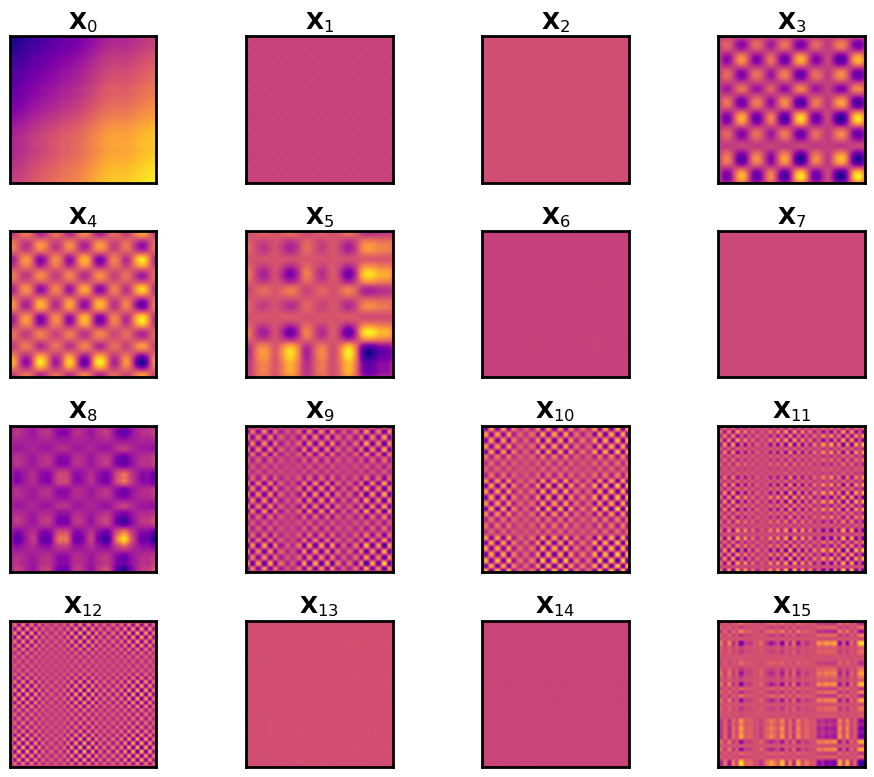

In [17]:
plot_komponen(X_komponen, d)

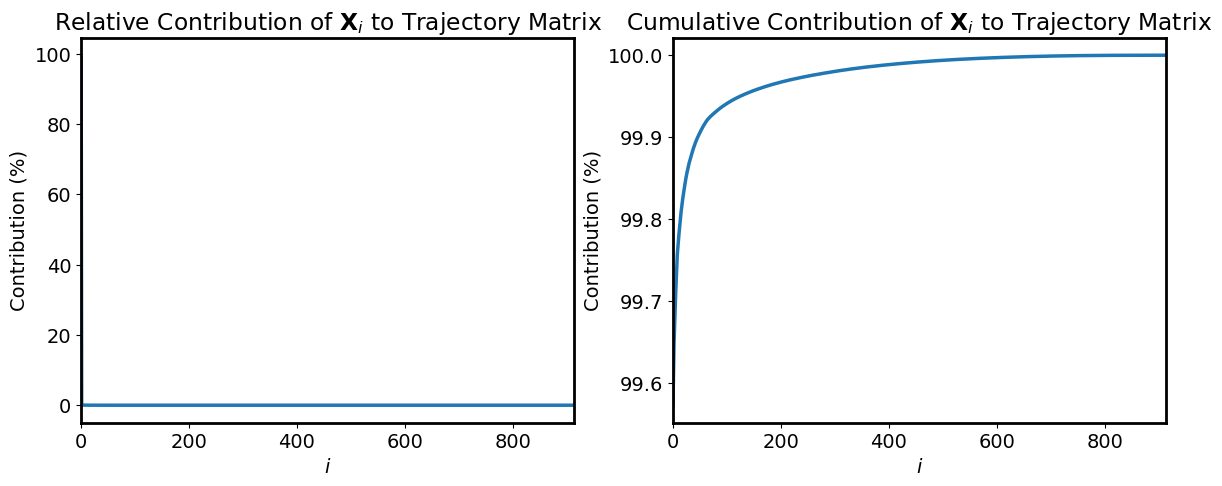

In [18]:
plot_kontribusi_komponen(Sigma, d)

<Figure size 10000x10000 with 0 Axes>

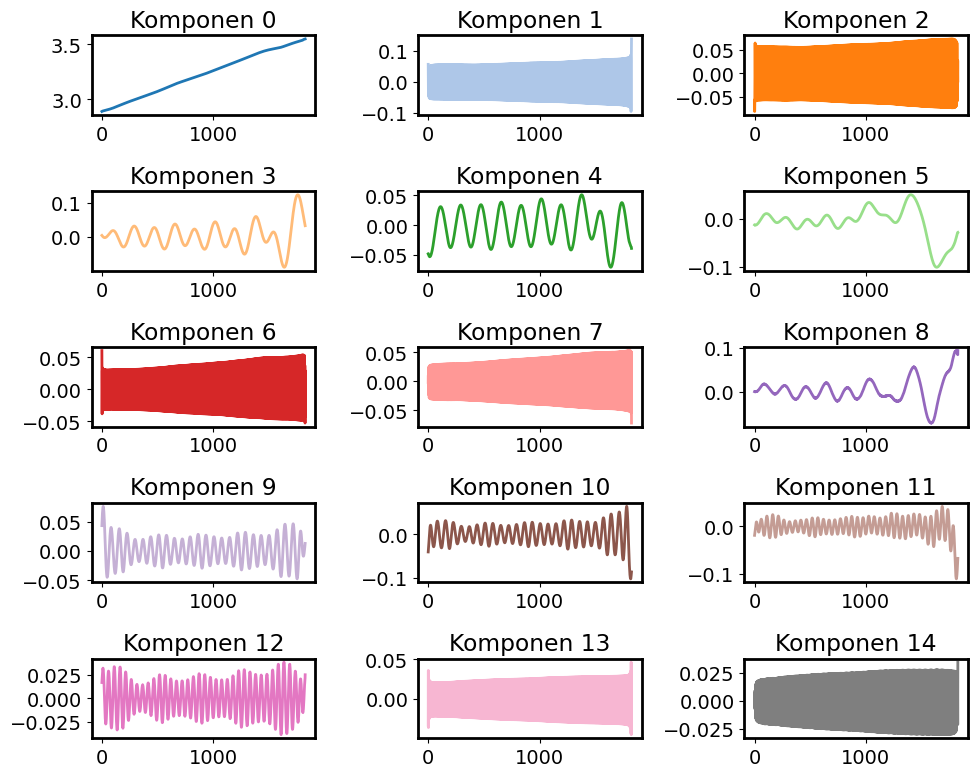

In [25]:
plot_komponen_multiline(F_i, data.index)


In [90]:
colors = plt.get_cmap('tab20').colors
for i in range(0, len(F_i)):
    plot_komponen_singleline(F_i[i], data.index, f"Komponen{i}", colors[i % len(colors)], [False, '../Image/SSA/L = 914/Komponen/'])

#### Seleksi komponen

In [40]:
# Membuat DataFrame Gabungan komponen
df_komponen = pd.DataFrame(np.array(F_i).T, columns=[f'Komponen_{i+1}' for i in range(0, 914)])
df_komponen

,Komponen_1,Komponen_2,Komponen_3,Komponen_4,Komponen_5,Komponen_6,Komponen_7,Komponen_8,Komponen_9,Komponen_10,...,Komponen_905,Komponen_906,Komponen_907,Komponen_908,Komponen_909,Komponen_910,Komponen_911,Komponen_912,Komponen_913,Komponen_914
0,2.890701,0.056699,-0.056922,0.004259,-0.047812,-0.012855,0.060086,-0.001794,0.000097,0.043193,...,0.000223,0.000561,-0.000065,0.000020,-0.000431,3.174568e-04,-2.759993e-05,0.000208,0.000068,-0.000182
1,2.891540,-0.008289,-0.080610,0.003780,-0.047612,-0.012478,-0.002485,0.010651,-0.000060,0.048182,...,-0.000099,-0.000522,-0.000053,-0.000012,0.000529,7.402615e-05,-1.787124e-05,-0.000253,0.000057,-0.000151
2,2.892249,-0.044620,-0.067453,0.003303,-0.048325,-0.012697,-0.038740,-0.022936,-0.000116,0.052782,...,0.000059,0.000413,-0.000024,-0.000023,-0.000505,-9.520609e-05,-6.847453e-05,0.000047,0.000111,-0.000013
3,2.892890,-0.032955,-0.018700,0.002886,-0.049336,-0.013023,0.016178,0.003693,0.000117,0.057134,...,-0.000038,-0.000608,0.000046,-0.000006,0.000483,-3.495730e-05,2.324262e-05,0.000100,0.000117,0.000016
4,2.893371,0.009510,0.037127,0.002492,-0.050239,-0.013149,0.029177,0.023699,0.000132,0.060855,...,0.000158,0.000674,0.000073,0.000026,-0.000434,5.382868e-05,-2.563528e-05,-0.000145,0.000088,-0.000009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,3.548826,-0.095272,-0.058166,0.040387,-0.036057,-0.030772,-0.044840,-0.054495,0.090320,0.004902,...,-0.000003,0.000013,0.000031,0.000097,-0.000251,3.780681e-06,-3.526443e-05,0.000080,-0.000061,0.000002
1823,3.549169,-0.043888,-0.024650,0.038452,-0.036138,-0.029617,0.036787,0.017023,0.091111,0.006897,...,0.000037,-0.000005,0.000141,0.000075,0.000238,4.834297e-06,1.163687e-05,-0.000151,-0.000014,-0.000122
1824,3.549483,0.049758,0.018489,0.036369,-0.036632,-0.028835,0.025728,0.050900,0.085874,0.008806,...,-0.000012,-0.000100,0.000059,-0.000049,-0.000239,-1.979077e-07,-5.358475e-06,-0.000034,0.000061,-0.000014
1825,3.549774,0.125839,0.027257,0.034337,-0.037805,-0.028812,-0.053135,-0.034387,0.084123,0.010714,...,-0.000035,0.000045,-0.000058,-0.000076,0.000257,-1.166277e-06,2.714707e-06,0.000121,0.000054,0.000142


Menentukan komponen noise

In [63]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller

In [87]:
model = VAR(df_komponen)
fit_model = model.fit()

# Ambil residual dari model
residuals = fit_model.resid

# Cek bentuk residuals
print(f"Shape of residuals: {residuals.shape}")

Shape of residuals: (1826, 914)


durbin watson 

In [65]:
# Hitung Durbin-Watson untuk setiap kolom
dw_stats = {}
for i in range(residuals.shape[1]):  # Loop untuk setiap kolom
    dw_stat = durbin_watson(residuals.iloc[:, i])
    dw_stats[f'Komponen_{i}'] = dw_stat

# Simpan hasil dalam DataFrame
dw_df = pd.DataFrame(list(dw_stats.items()), columns=['Komponen', 'Durbin-Watson Statistic'])
print(dw_df.head())

     Komponen  Durbin-Watson Statistic
0  Komponen_0                 0.066393
1  Komponen_1                 0.759661
2  Komponen_2                 0.759809
3  Komponen_3                 0.013290
4  Komponen_4                 0.013535


In [118]:
dw_df['Is Noise'] = False
dw_df.loc[(dw_df['Durbin-Watson Statistic'] >= 1.75) & (dw_df['Durbin-Watson Statistic'] <= 2.75), 'Is Noise'] = True

In [119]:
indeks_bukan_noise = dw_df[dw_df['Is Noise'] == False].index
indeks_bukan_noise

Index([  0,   1,   2,   3,   4,   5,   8,   9,  10,  11,
       ...
       891, 892, 893, 894, 895, 897, 901, 902, 905, 906],
      dtype='int64', length=651)

## Rekonstruksi

In [143]:
def rekonstruksi(type, value, F_i):
    F_rekonstruksi = np.zeros_like(F_i[0])
    indeks = 0
    if(type == 0):
        indeks = range(0,value)
    elif(type == 1):
        indeks = value
        
    for i in indeks:
        F_rekonstruksi += F_i[i]
    return pd.DataFrame({'Date':data.index, 'Value':F_rekonstruksi})

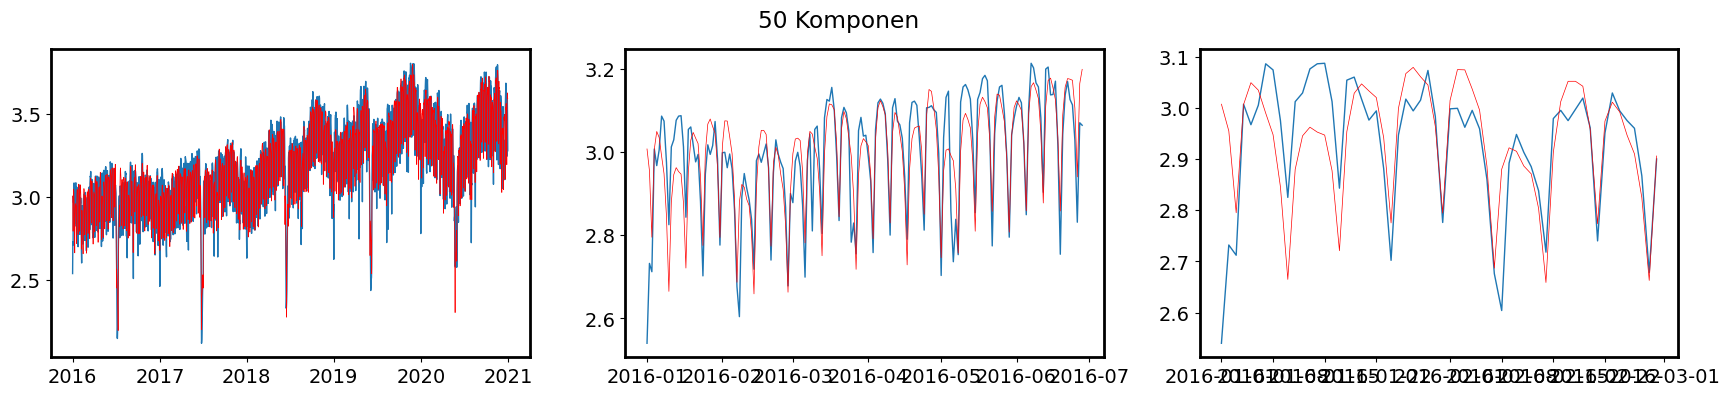

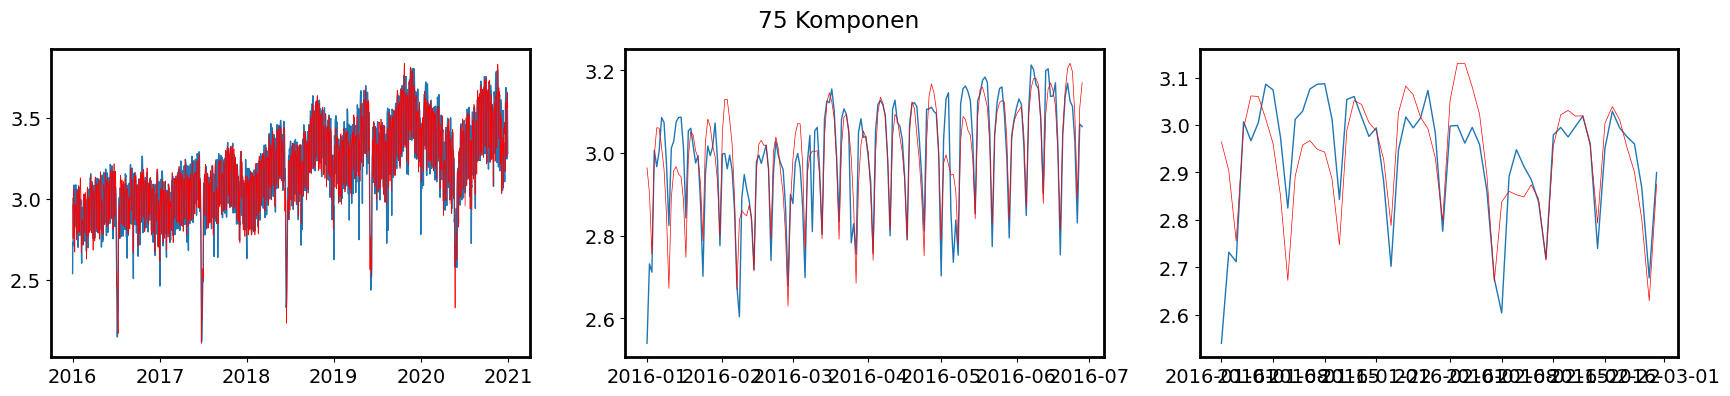

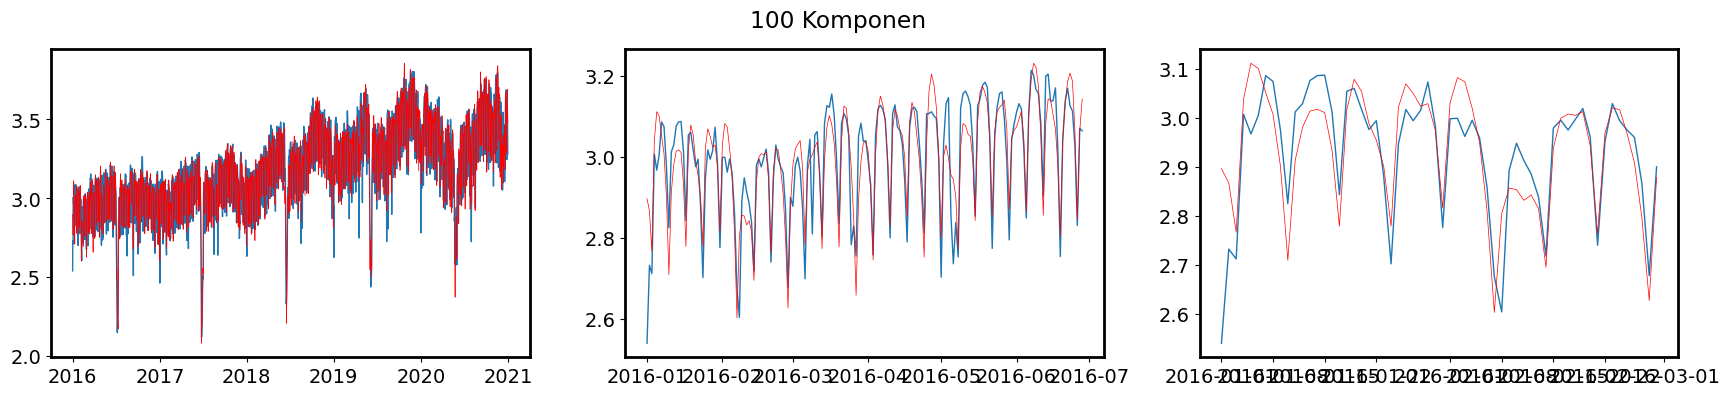

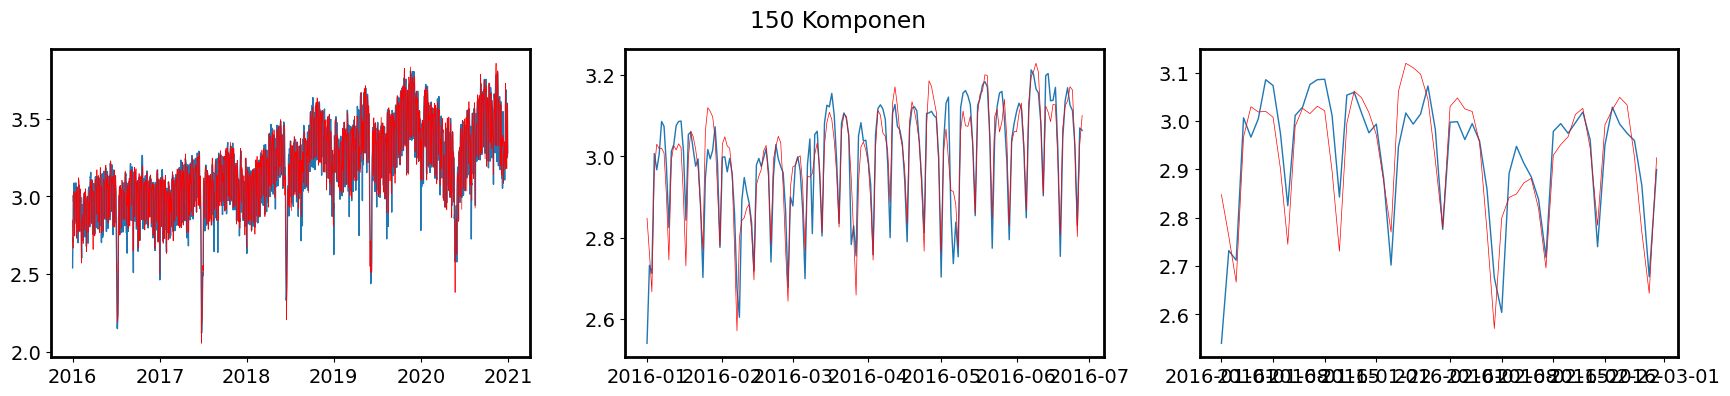

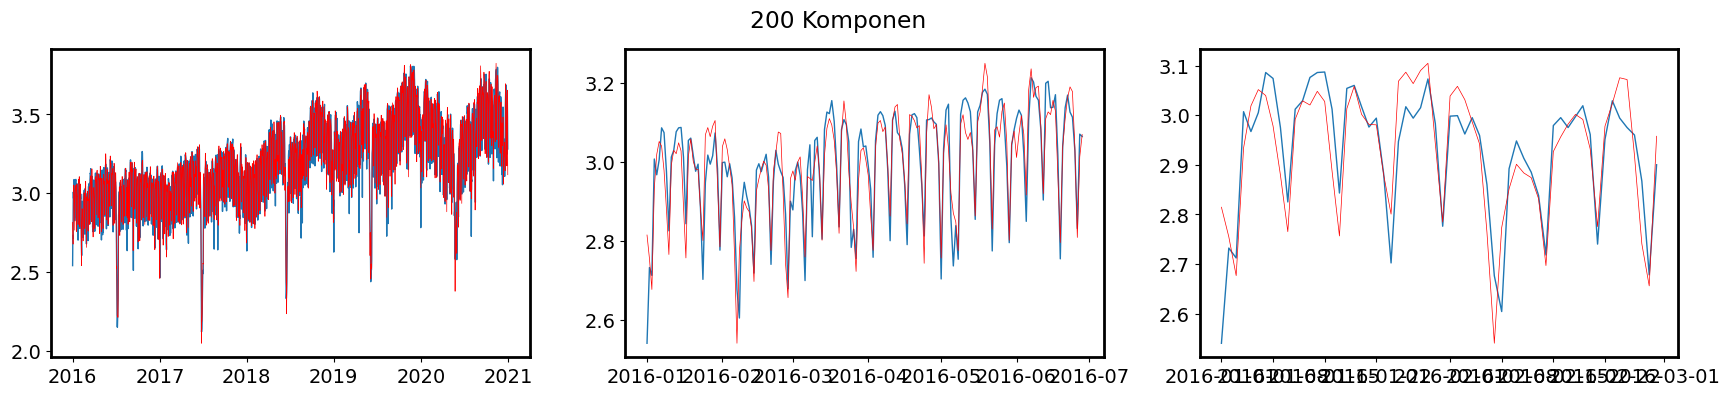

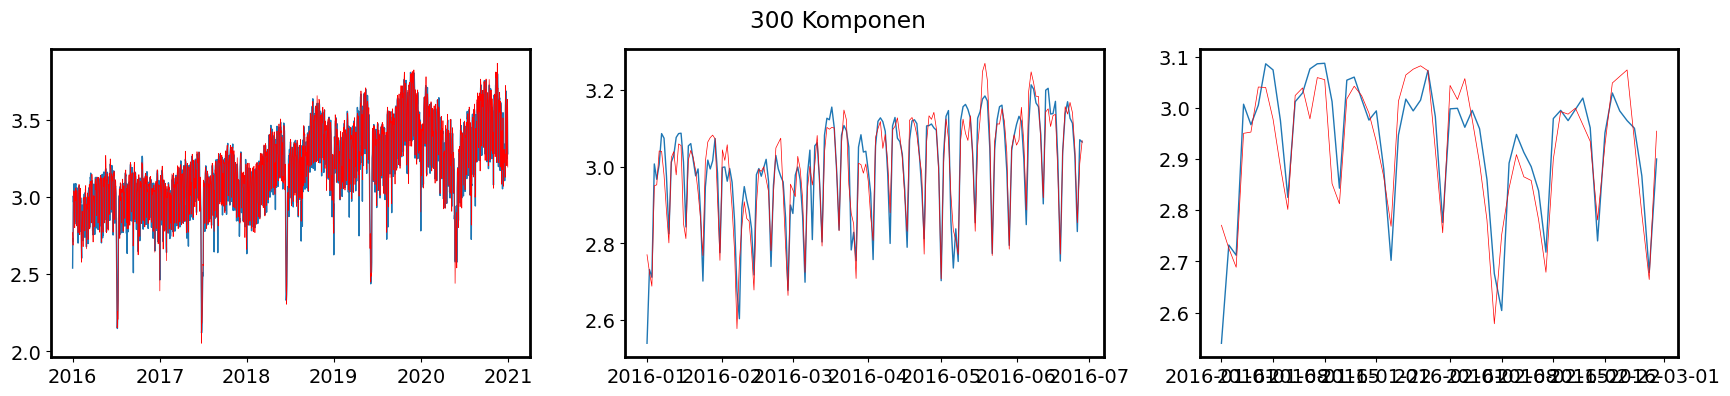

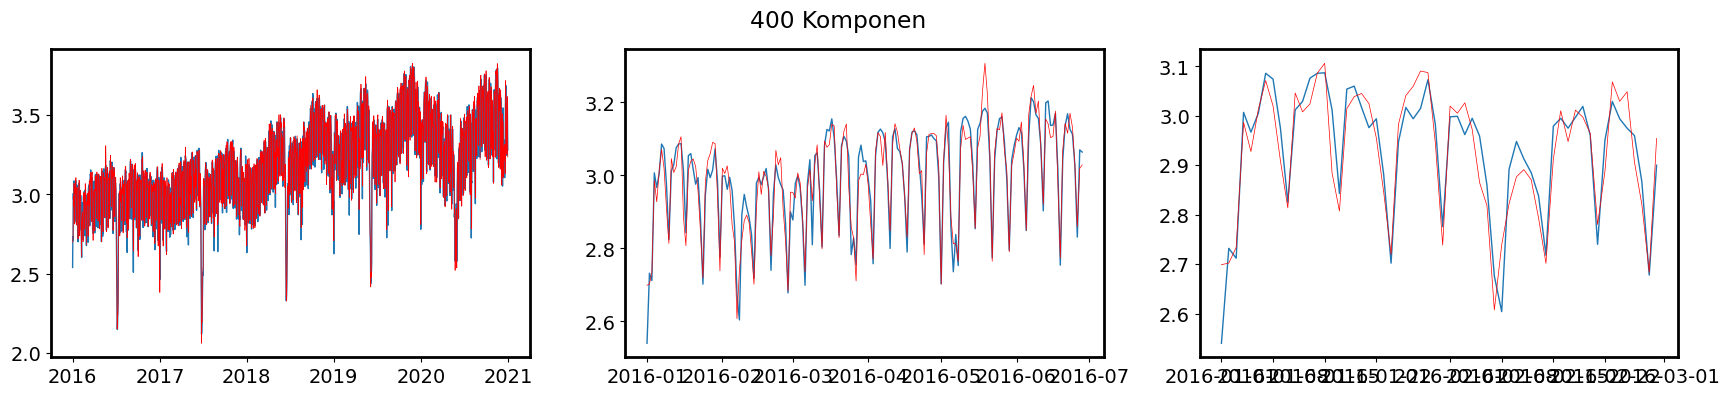

In [176]:
for i in [50, 75, 100, 150, 200, 300, 400]:
    df_rekonstruksi = rekonstruksi(0, i, F_i)
    fig, axes = plt.subplots(1,3, figsize=(21, 4))
    show = 1827
    axes[0].plot(data.index[:show], data[:show], label='Real', lw=1)
    axes[0].plot(data.index[:show], df_rekonstruksi['Value'][:show], color='red', label='Rekonstruksi', lw=0.5)
    show = 180
    axes[1].plot(data.index[:show], data[:show], label='Real', lw=1)
    axes[1].plot(data.index[:show], df_rekonstruksi['Value'][:show], color='red', label='Rekonstruksi', lw=0.5)
    show = 60
    axes[2].plot(data.index[:show], data[:show], label='Real', lw=1)
    axes[2].plot(data.index[:show], df_rekonstruksi['Value'][:show], color='red', label='Rekonstruksi', lw=0.5)
    fig.suptitle(f'{i} Komponen')

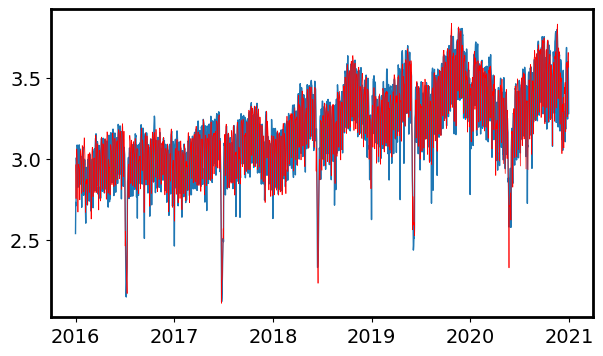